In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from os import walk
import re
from scipy.signal import savgol_filter
from scipy.signal import find_peaks, find_peaks_cwt
from scipy import signal

import matplotlib.gridspec as gridspec
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

data_dir = 'Messungen'

import os
from os.path import join
def getFileContent(path_dir):
    return_Dict = {}
    for root, dirs, files in os.walk(path_dir):
        for file in files:
            if file[-3:].lower() == "csv":
                return_Dict[file] = os.path.join(root,file)  
    return return_Dict
dic = getFileContent(data_dir) 
print(dic.keys())

dict_keys(['15% v20_10%.CSV', '15% v20_20%.CSV', '15% v40_20%.CSV', '20190828 v20,10-1-reissen.CSV', '20190828 v20,10-1-reissen2.CSV', '20190828 v20,10-1.CSV', '20190828 v20,10-2-reissen.CSV', '20190828 v20,10-2.CSV', '20190828 v20,20-1-reissen.CSV', '20190828 v20,20-1.CSV', '20190828 v20,20-1wdh.CSV', '20190828 v40-3-reissen.CSV', '20190828 v40-3-reissen2.CSV', '20190828 v40-3.CSV', '20190828 v20,20-3,reissen.CSV', '20190828 v20,20-3.CSV', '20190828 v40-2-reissen.CSV', '20190828 v40-2.CSV', '20190828 v20,20-2,reissen.CSV', '20190828 v20,20-2.CSV', '20190828 v40-1-reissen.CSV', '20190828 v40-1.CSV', '20190828 v20-3-reissen.CSV', '20190828 v20-3.CSV'])


In [5]:
# split data for cyclical analysis and ripping force analysis
# read all csv data into one list 
datasets = {}#filename = []

#renaming those absolutely horribly chosen column names
names = ['Points','Elapsed_Time_Sec','Scan_Time_Sec','Disp_mm','Load_2_N','E12_%','E22_%','Axial_cmd_V','Axial_err_%','Unnamed']
for key in dic.keys():
    #print(key)
    len_tmp = pd.read_csv(dic[key], index_col = False, names=names).shape[0]
    if len_tmp >2:
        datasets[key] = pd.read_csv(dic[key],header = 2, index_col = False, names=names)
        datasets[key]['Short'] = 0
        #if re.search(r"reis", key) == 1:
        #    print('RISS')
        #print(datasets[key].head())
    else:
        #print('tiny data set')
        datasets[key] = pd.read_csv(dic[key], index_col = False, names=names)
        datasets[key]['Short'] = 1
        #print('short')
    len_tmp = 0
    
#manually read out the initial error steps in the datasets 
n_init_r = {'20_10_1_r' : 1000, 
			'20_10_2_r' : 350, 
			'20_10_3_r' : 550, 
			'20_20_1_r': 300,
			'20_20_2_r': 500,
			'20_20_3_r': 0,
			'40_1_r': 800,
			'40_2_r': 200,
			'40_3_r': 700,
			'40_3_r2':700}



data_rip = {#'20_10_1_r': datasets['20190828 v20,10-1-reissen.CSV'],
            #'20_10_2_r': datasets['20190828 v20,10-2-reissen.CSV'],
            '20_10_3_r': datasets['20190828 v20-3-reissen.CSV'],
            #'20_20_1_r': datasets['20190828 v20,20-1-reissen.CSV'],
            '20_20_2_r': datasets['20190828 v20,20-2,reissen.CSV'],
            #'20_20_3_r': datasets['20190828 v20,20-3,reissen.CSV'],
            #'40_1_r': datasets['20190828 v40-1-reissen.CSV'],
            '40_2_r': datasets['20190828 v40-2-reissen.CSV'],
            #'40_3_r': datasets['20190828 v40-3-reissen.CSV'],
            #'40_3_r2': datasets['20190828 v40-3-reissen2.CSV']
            }

#dimensions in the form height x width x length
dimensions_mm = {'20_10_1':[0.580,5,2],
                '20_10_2':[0.580,5,2],
                '20_10_3':[0.580,5,1.5],
                '20_20_1':[0.580,4.5,1.5],
                '20_20_2':[0.580,5,1.5],
                '20_20_3':[0.580,5,2],
                '40_1':[0.580,4,1],
                '40_2':[0.580,5,1],
                '40_3':[0.580,3.5,1],
                '20_10_1_r':[0.580,5,2],
                '20_10_2_r':[0.580,5,2],
                '20_10_3_r':[0.580,5,1.5],
                '20_20_1_r':[0.580,4.5,1.5],
                '20_20_2_r':[0.580,5,1.5],
                '20_20_3_r':[0.580,5,2],
                '40_1_r':[0.580,4,1],
                '40_2_r':[0.580,5,1],
                '40_3_r':[0.580,3.5,1],
                '40_3_r2':[0.580,3.5,1]
                }

idx_max = {     '20_10_1_r':0,
                '20_10_2_r':[1950,1970],
                '20_10_3_r':[1950,1970],
                '20_20_1_r':0,
                '20_20_2_r':[1480,1510],
                '20_20_3_r':0,
                '40_1_r':0,
                '40_2_r':[1390,1410],
                '40_3_r':[1400,1415],
                '40_3_r2':[1180,1190]}

titles = {'20_10_1': 'ULD-V20-ULD, 10 % \n Sample 1',
            '20_10_2': 'Sample 2',
            '20_10_3': 'Sample 3',
            '20_20_1': 'ULD-V20-ULD, 20 % \n Sample 1',
            '20_20_2': 'Sample 2',
            '20_20_3': 'Sample 3',
            '40_1': 'ULD-V40-ULD, 20 % \n Sample 1',
            '40_2': 'Sample 2',
            '40_3': 'Sample 3',
            }

    
#for key in data_rip.keys():
#    data_rip[key] = data_rip[key][n_init_r[key]:]

data_rip['20_10_3_r'] = data_rip['20_10_3_r'].iloc[:-20] 


print(30*'='+'MAXIMUM STRESS'+30*'=')
for key in data_rip.keys():
    print('{} has shape '.format(key), data_rip[key].shape)



==============================MAXIMUM STRESS==============================
20_10_3_r has shape  (2061, 11)
20_20_2_r has shape  (1650, 11)
40_2_r has shape  (1571, 11)


In [6]:
def baseline_als(y, lam, p, niter=10):
    from scipy import sparse
    from scipy.sparse.linalg import spsolve
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\alexander resch\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


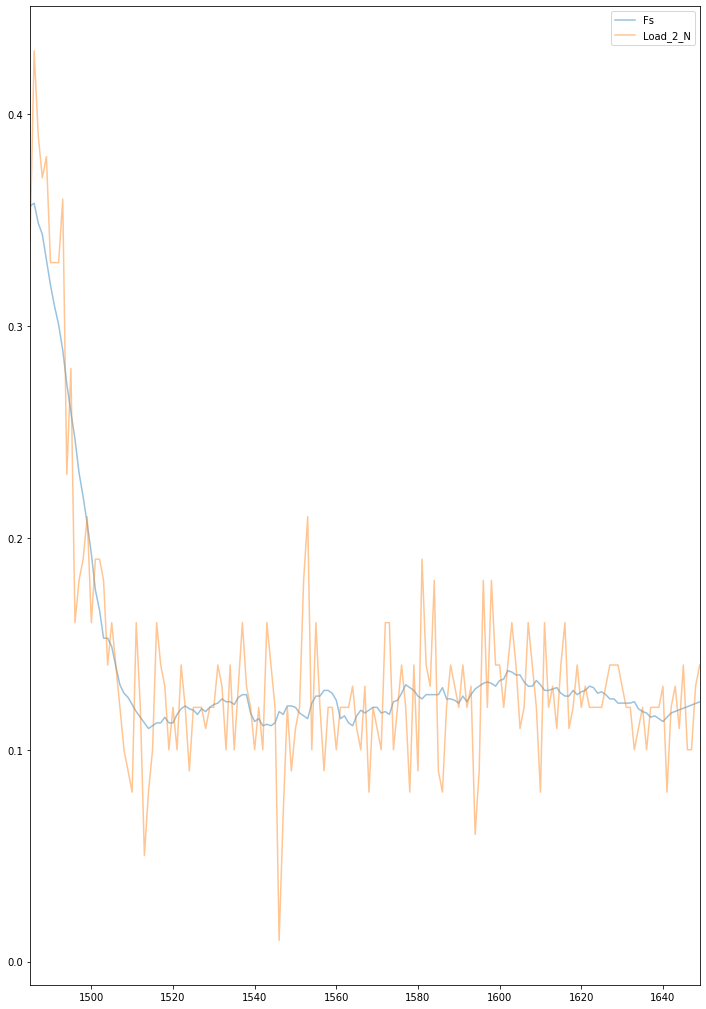

In [46]:
k = '20_20_2_r'
d = data_rip[k].copy()
d['Fs'] = savgol_filter(d.Load_2_N,15,1)

f = plt.figure(figsize = (12,18))
ax = f.add_subplot()
#d.plot(y=['Fs','Load_2_N'],alpha=0.45,ax=ax)
d.iloc[1485:].plot(y=['Fs','Load_2_N'],alpha=0.45,ax=ax)

In [30]:
h = dimensions_mm[k][0] 
b = dimensions_mm[k][1]
l = dimensions_mm[k][2]
sigma = (d.iloc[1200:1450]['Fs'].max()-d.iloc[1200:1450]['Fs'].min()) / (h*b)

In [31]:
sigma*1e6

67586.20689655172